In [1]:
getwd() # working directory 
ls()    # currently nothing in my R workspace

[1] "/Users/dsp/dongmei/climate-space/notebooks"

character(0)

In [2]:
source('../R/damian/getPseudoDaily.R')  # load .R source file

# now the functions/objects in the file are available
ls()                      

[1] "get.a.j"                "get.a.nought"           "get.b.j"               
[4] "get.daily.from.monthly" "interpolate.daily"

### Simulate monthly data
Represents monthly means and monthly lows for years _t-1_ and _t_

In [3]:
# Sample monthly means: t-1, t
monthly.means <- c(
  Jan.tm=3.3, Feb.tm=7.8, Mar.tm=8.9, Apr.tm=15.6, May.tm=16.1, 
  Jun.tm=22.2, Jul.tm=23.3, Aug.tm=23.3, Sep.tm=22.2, Oct.tm=16.1, 
  Nov.tm=12.2, Dec.tm=2.8, 
  Jan.t=5.6, Feb.t=12.2, Mar.t=12.8, Apr.t=17.2, May.t=18.9, 
  Jun.t=25.0, Jul.t=25.6, Aug.t=26.1, Sep.t=23.9, Oct.t=20.0, 
  Nov.t=12.8, Dec.t=6.7)
monthly.lows <- monthly.means + rnorm(12, -5, 2)
monthly.highs <- monthly.means + rnorm(12, +5, 2)

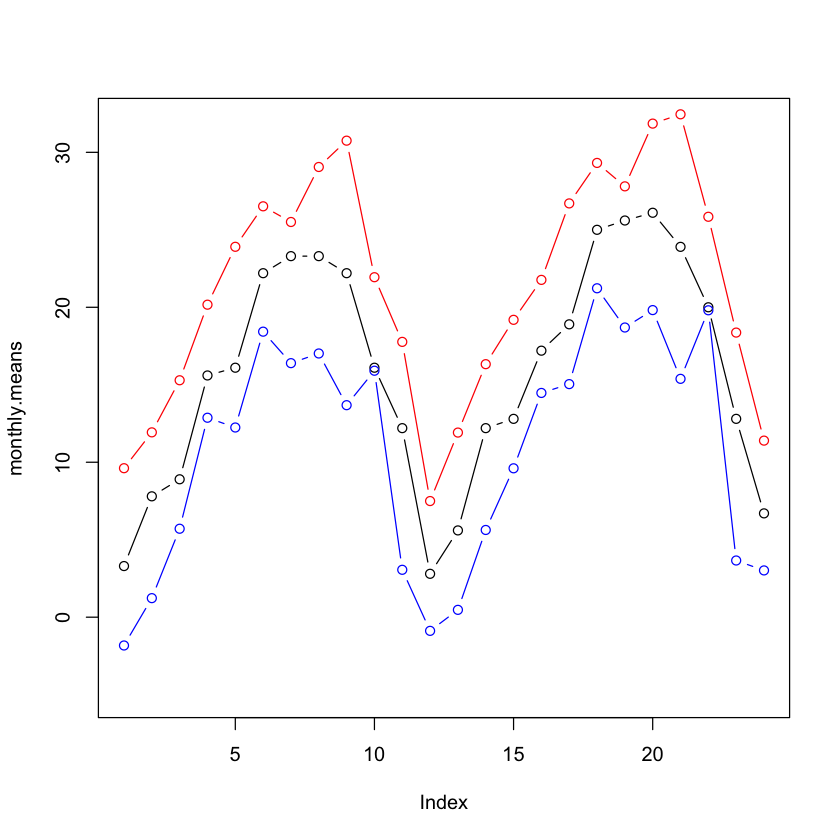

In [4]:
months <- 1:24
plot(monthly.means, type='b',ylim=c(-5, 32))
lines(monthly.lows, type='b', col=4)
lines(monthly.highs, type='b', col=2)

In [5]:
is.leap.year <- function(year) {
  ifelse(year %% 4 == 0 & year %% 100 != 0, T, F)
}

In [6]:
has.n.consecutive.trues <- function(x, n) {
  max.consec <- 0
  for (val in x) {
    if (val) {
      max.consec <- max.consec + 1
      if (max.consec >= n) {
        return (T)
      }
    } else {
      max.consec <- 0
    }
  }
  F
}

In [7]:
is.coldsnap <- function(daily.lows) {
  candidates <- daily.lows <= -20
  1 * has.n.consecutive.trues(candidates, 4)
}

In [8]:
get.summer.t40 <- function(daily.highs) {
  sum(daily.highs > 40)
}

In [9]:
get.single.year.data <- function(year, monthly.lows, monthly.highs) {
  leap.year <- is.leap.year(year)
  n.days <- ifelse(leap.year, 366, 365)
  daily.lows  <- get.daily.from.monthly(monthly.lows,  n.days)
  daily.highs <- get.daily.from.monthly(monthly.highs, n.days)
  MAR <- 60
  APR <- 91
  JUN <- 152
  AUG <- 213  
  Lcs.range <- MAR:(APR + 14)
  aug.range <- AUG:(AUG + 30)
  summer.range <- JUN:(AUG + 30)
  if (leap.year) {
    Lcs.range <- Lcs.range + 1
    aug.range <- aug.range + 1
    summer.range <- summer.range + 1
  }
  Lcs <- is.coldsnap(daily.lows[Lcs.range])
  maxAugT <- max(daily.highs[aug.range])
  summerT40 <- get.summer.t40(daily.highs[summer.range])
  list(Lcs=Lcs, maxAugT=maxAugT, summerT40=summerT40)
}

In [10]:
get.coldsnap.stats <- function(daily.lows) {
  n.coldsnap <- 0
  length.coldsnap <- c()
  below.neg20 <- daily.lows <= -20
  consec.days <- 0
  for (day in below.neg20) {
    if (day) {
      consec.days <- consec.days + 1
    } else {
      if (consec.days > 3) {
        n.coldsnap <- n.coldsnap + 1
        length.coldsnap <- c(length.coldsnap, consec.days)
        consec.days <- 0
      } else {
        consec.days <- 0
      }
    }
  }
  Acs <- ifelse(length(length.coldsnap), mean(length.coldsnap), 0)
  list(Ncs=n.coldsnap, Acs=Acs)
}

In [11]:
get.drop.stats <- function(daily.means) {
  daily.changes <- diff(daily.means)
  drop0 <- sum(daily.changes >= 0)
  drop5 <- sum(daily.changes < 0 & daily.changes >= -5)
  drop10 <- sum(daily.changes < -5 & daily.changes >= -10)
  drop15 <- sum(daily.changes < -10 & daily.changes >= -15)
  drop20 <- sum(daily.changes < -15 & daily.changes >= -20)
  drop20plus <- sum(daily.changes < -20)
  max.drop <- abs(min(daily.changes))
  list(drop0=drop0, drop5=drop5, drop10=drop10, drop15=drop15, 
       drop20=drop20, drop20plus=drop20plus, max.drop=max.drop)
}

In [43]:
get.degree.days <- function(daily.means) {
  n <- length(daily.means)
  above5.5.aug.jul <- daily.means > 5.5
  above5.5.aug.jun <- above5.5.aug.jul[1:(n-31)]
  ddAugJul <- sum(daily.means[which(above5.5.aug.jul)])
  ddAugJun <- sum(daily.means[which(above5.5.aug.jun)])
  list(ddAugJul=ddAugJul, ddAugJun=ddAugJun)
}

In [44]:
get.two.year.data <- function(start.year, monthly.means, monthly.lows) {
  y2.leap <- is.leap.year(start.year + 1)
  n.days <- ifelse(y2.leap, 366, 365)
  OCT <- 62
  NOV <- 93
  DEC <- 123
  FEB <- 185
  winter.range <- DEC:(FEB + 27)
  Ecs.range <- (OCT + 14):(NOV + 29)
  if (y2.leap) {
    winter.range <- DEC:(FEB + 28)
  }
  daily.means <- get.daily.from.monthly(monthly.means, n.days)
  daily.lows  <- get.daily.from.monthly(monthly.lows,  n.days)

  winterTmin <- min(daily.lows[winter.range])
  Ecs <- is.coldsnap(daily.lows[Ecs.range])
  coldsnap.stats <- get.coldsnap.stats(daily.lows[winter.range])
  drop.data <- get.drop.stats(daily.means[winter.range])
  degree.days.data <- get.degree.days(daily.means)
  list(winterTmin=winterTmin, Ecs=Ecs, coldsnap.stats=coldsnap.stats,
       drop.data=drop.data, degree.days.data=degree.days.data)
}

In [45]:
# get.daily.stats requires 2 years of monthly statistics from Jan (t-1) to 
# Dec (t)
# Args:
#   start.year: numeric; year of t-1
#   monthly.highs: numeric vector; 24 data points of monthly highs
#   monthly.means: ""      ""      "" ""   ""     "" ""      means
#   monthly.lows:  ""      ""      "" ""   ""     "" ""      lows
get.daily.stats <- function(
    start.year, monthly.highs, monthly.means, monthly.lows) {
  t <- start.year + 1
  AUG <- 8
  YEAR <- 12
  # Months Aug (t-1)- Jul (t)
  aug.jul.range <- AUG:(AUG + YEAR - 1)
  # Months Jan (t) - Dec (t)
  jan.dec.range <- (YEAR + 1):(2*YEAR)
  
  t.data <- get.single.year.data(
    t, monthly.lows[jan.dec.range], monthly.highs[jan.dec.range]) 
  two.year.data <- get.two.year.data(start.year, 
                                     monthly.means[aug.jul.range], 
                                     monthly.lows[aug.jul.range])
  out <- c(unlist(t.data), unlist(two.year.data))
  names(out) <- gsub('coldsnap.stats.|drop.data.|degree.days.data.', '', names(out))
  out
}

get.daily.stats(1976, monthly.highs, monthly.means, monthly.lows)

Lcs      maxAugT    summerT40   winterTmin          Ecs          Ncs 
   0.0000000   33.5586575    0.0000000   -1.7723533    0.0000000    0.0000000 
         Acs        drop0        drop5       drop10       drop15       drop20 
   0.0000000   56.0000000   33.0000000    0.0000000    0.0000000    0.0000000 
  drop20plus     max.drop     ddAugJul     ddAugJun 
   0.0000000    0.3761365 5553.1145606 4722.2543739